来自：https://aayushmnit.com/posts/2022-11-17-DiffEdit/2022-11-17-DiffEdit.html

![model](/home/tansq1/project/diffusers/image/DiifEdit.png)

In [1]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms


#导入相关包 定义函数

## Basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

## Helper functions

def load_artifacts():
    '''
    A function to load all diffusion artifacts
    '''
    path = '/home/tansq1/project/diffusers/pretrain_model/stable-diffusion-v1-4'
    vae = AutoencoderKL.from_pretrained(path, subfolder="vae", torch_dtype=torch.float16).to("cuda")
    unet = UNet2DConditionModel.from_pretrained(path, subfolder="unet", torch_dtype=torch.float16).to("cuda")
    tokenizer = CLIPTokenizer.from_pretrained(path, subfolder="tokenizer", torch_dtype=torch.float16)
    text_encoder = CLIPTextModel.from_pretrained(path, subfolder="text_encoder", torch_dtype=torch.float16).to("cuda")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)    
    return vae, unet, tokenizer, text_encoder, scheduler

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

vae, unet, tokenizer, text_encoder, scheduler = load_artifacts()

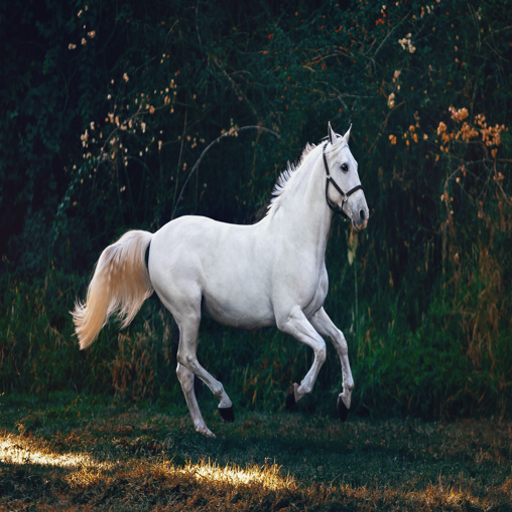

In [2]:
#查看需要用到的图片

init_img = load_image('/home/tansq1/project/diffusers/image/3.png')
init_img

### 一.计算mask
###### 用两个不同文本的去噪结果来计算mask。原文提到，计算十次取平均

In [3]:
#之前的img2img函数。修改了一下，返回图片改成返回latent

def prompt_2_img_i2i(prompts, init_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""], text.shape[1])
    else: uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        #latents = scheduler.step(pred, ts, latents).pred_original_sample
        latents = scheduler.step(pred, ts, latents).prev_sample
    
    # Returning the latent representation to output an array of 4x64x64
    return latents.detach().cpu()

In [4]:
# 计算mask的函数
# 不过和我理解的不太一样，我觉得是一次去噪的噪声，这里是从当前到x0的噪声，是很多次的噪声。
# 原文说的是平均10次，缩放到[0,1]，然后0.5为阈值进行二值化。这里的实现不一样

def create_mask(init_img, rp, qp, n=10, s=0.5):
    ## Initialize a dictionary to save n iterations
    diff = {}
    
    ## Repeating the difference process n times
    for idx in range(n):
        ## Creating denoised sample using reference / original text
        orig_noise = prompt_2_img_i2i(prompts=rp, init_img=init_img, strength=s, seed = 100*idx)[0]
        ## Creating denoised sample using query / target text
        query_noise = prompt_2_img_i2i(prompts=qp, init_img=init_img, strength=s, seed = 100*idx)[0]
        ## Taking the difference 
        diff[idx] = (np.array(orig_noise)-np.array(query_noise))
    
    ## Creating a mask placeholder
    mask = np.zeros_like(diff[0])
    
    ## Taking an average of 10 iterations
    for idx in range(n):
        ## Note np.abs is a key step
        mask += np.abs(diff[idx])  
        
    ## Averaging multiple channels 
    mask = mask.mean(0)    #latent是有多个通道的，这里取均值。注意mask后会改变维度
    
    ## Normalizing 
    mask = (mask - mask.mean()) / np.std(mask)  #转化成均值为0，方差为1的高斯分布。
    
    ## Binarizing and returning the mask object
    return (mask > 0).astype("uint8")           #二值化

mask = create_mask(init_img=init_img, rp=["a horse image"], qp=["a zebra image"], n=10)

100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


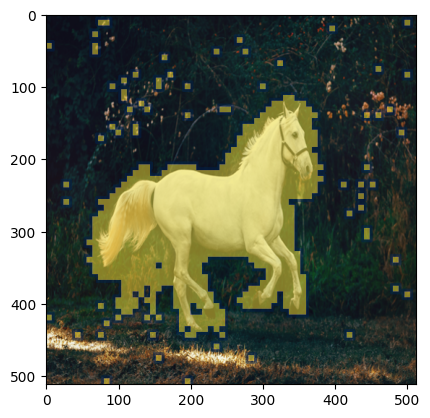

In [5]:
#展示mask

plt.imshow(np.array(init_img), cmap='gray') # I would add interpolation='none'
plt.imshow(
    Image.fromarray(mask).resize((512,512)), ## Scaling the mask to original size
    cmap='cividis', 
    alpha=0.5*(np.array(Image.fromarray(mask*255).resize((512,512))) > 0)  
)

### 二.利用mask进行图像编辑


In [6]:
# 这里的ddim加噪，就直接用ddim scheduler加噪，调个函数即可。所以所谓的ddim前向和反向，只是scheduler调个函数
# 注意这里的未修改的部分，以前的论文是用x0加噪的方式，这里不一样，用的是当前图片去噪的形式(用的原图文本)。
# 当然，我觉得这是因为这个算法多了一个原图文本的输入，才可以这样。这样直觉上来说，边缘会好一些，比起直接从x0加噪过来

def prompt_2_img_diffedit(rp, qp, init_img, mask, g=7.5, seed=100, strength =0.7, steps=70, dim=512):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    rtext = text_enc(rp) 
    qtext = text_enc(qp)
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""], rtext.shape[1])
    emb = torch.cat([uncond, rtext, qtext])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Converting mask to torch tensor
    mask = torch.tensor(mask, dtype=unet.dtype).unsqueeze(0).unsqueeze(0).to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 3), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u, rt, qt = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(3)
            
        # Performing Guidance
        rpred = u + g*(rt-u)
        qpred = u + g*(qt-u)

        # Conditioning  the latents
        rlatents = scheduler.step(rpred, ts, latents).prev_sample
        qlatents = scheduler.step(qpred, ts, latents).prev_sample
        latents = mask*qlatents + (1-mask)*rlatents
    
    # Returning the latent representation to output an array of 4x64x64
    return latents_to_pil(latents)

100%|██████████| 35/35 [00:04<00:00,  7.11it/s]


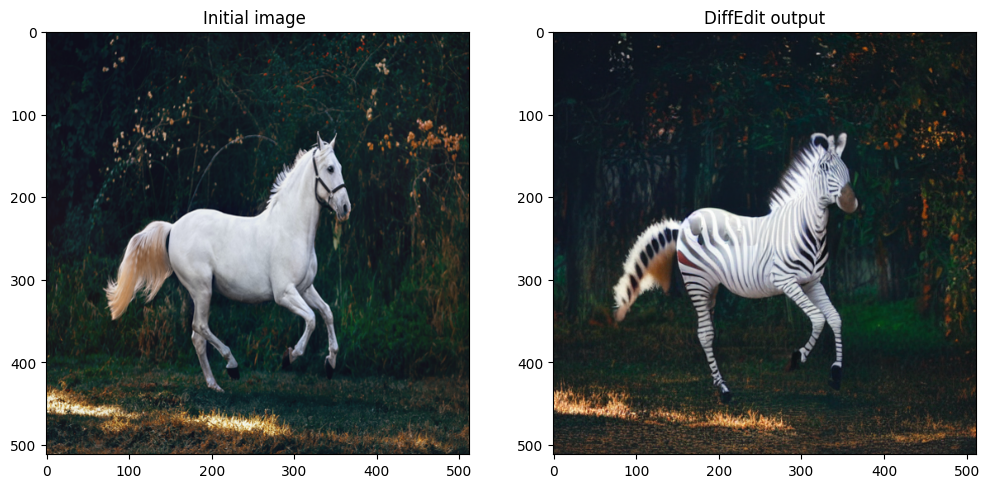

In [7]:
# 可视化
# 其实可以看到背景没有很好的保留，不知道是不是只是这个复现版本的问题。这是一个可以改进的方向。只有复现问题才会发现可改变的地方
# 我觉得一个原因是mask有离散点，比如mask的离散点去除。用一个bfs，保留最大联通块
# 还有一个原因是替换的时候不是x0的加噪，x0的加噪在最后一步是可以保证完全一样的。这篇论文的ddim encode的方法有累计误差

output = prompt_2_img_diffedit(
    rp = ["a horse image"], 
    qp=["a zebra image"],
    init_img=init_img, 
    mask = mask, 
    g=7.5, seed=100, strength =0.5, steps=70, dim=512)

## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate([init_img, output[0]]): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"Initial image ")
    else: axs[c].set_title(f"DiffEdit output")

100%|██████████| 49/49 [00:07<00:00,  6.87it/s]


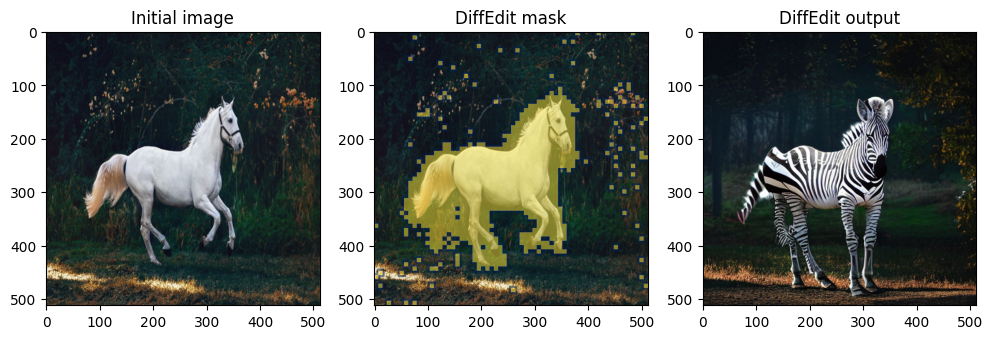

In [8]:
#整理一下，写一个接口

def diffEdit(init_img, rp , qp, g=7.5, seed=100, strength =0.7, steps=70, dim=512):
    
    ## Step 1: Create mask
    mask = create_mask(init_img=init_img, rp=rp, qp=qp)
    
    ## Step 2 and 3: Diffusion process using mask
    output = prompt_2_img_diffedit(
        rp = rp, 
        qp=qp, 
        init_img=init_img, 
        mask = mask, 
        g=g, 
        seed=seed,
        strength =strength, 
        steps=steps, 
        dim=dim)
    return mask , output

def plot_diffEdit(init_img, output, mask):
    ## Plotting side by side
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    ## Visualizing initial image
    axs[0].imshow(init_img)
    axs[0].set_title(f"Initial image")
    
    ## Visualizing initial image
    axs[2].imshow(output[0])
    axs[2].set_title(f"DiffEdit output")
    
    ## Visualizing the mask 
    axs[1].imshow(np.array(init_img), cmap='gray') 
    axs[1].imshow(
        Image.fromarray(mask).resize((512,512)), ## Scaling the mask to original size
        cmap='cividis', 
        alpha=0.5*(np.array(Image.fromarray(mask*255).resize((512,512))) > 0)  
    )
    axs[1].set_title(f"DiffEdit mask")


init_img = load_image('/home/tansq1/project/diffusers/image/3.png')
mask, output = diffEdit(init_img, rp = ["a horse image"], qp=["a zebra image"])
plot_diffEdit(init_img, output, mask)

### 三.更快的实现版本
###### 上面是原文的实现。现在尝试更快的实现版本

In [9]:
#直接用ddim一步到x0，而不是分很多step进行去噪。
#下面就是返回一次去噪的结果

def prompt_2_img_i2i_fast(prompts, init_img, g=7.5, seed=100, strength =0.5, steps=50, dim=512):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""], text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # We need to scale the i/p latents to match the variance
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), timesteps)
    # Predicting noise residual using U-Net
    with torch.no_grad(): u,t = unet(inp, timesteps, encoder_hidden_states=emb).sample.chunk(2)
         
    # Performing Guidance
    pred = u + g*(t-u)

    # Zero shot prediction
    latents = scheduler.step(pred, timesteps, latents).pred_original_sample #一步到x0
    
    # Returning the latent representation to output an array of 4x64x64
    return latents.detach().cpu()

In [10]:
#重复次数从10次到20次

def create_mask_fast(init_img, rp, qp, n=20, s=0.5):
    ## Initialize a dictionary to save n iterations
    diff = {}
    
    ## Repeating the difference process n times
    for idx in range(n):
        ## Creating denoised sample using reference / original text
        orig_noise = prompt_2_img_i2i_fast(prompts=rp, init_img=init_img, strength=s, seed = 100*idx)[0]
        ## Creating denoised sample using query / target text
        query_noise = prompt_2_img_i2i_fast(prompts=qp, init_img=init_img, strength=s, seed = 100*idx)[0]
        ## Taking the difference 
        diff[idx] = (np.array(orig_noise)-np.array(query_noise))
    
    ## Creating a mask placeholder
    mask = np.zeros_like(diff[0])
    
    ## Taking an average of 10 iterations
    for idx in range(n):
        ## Note np.abs is a key step
        mask += np.abs(diff[idx])  
        
    ## Averaging multiple channels 
    mask = mask.mean(0)
    
    ## Normalizing 
    mask = (mask - mask.mean()) / np.std(mask)
    
    ## Binarizing and returning the mask object
    return (mask > 0).astype("uint8")

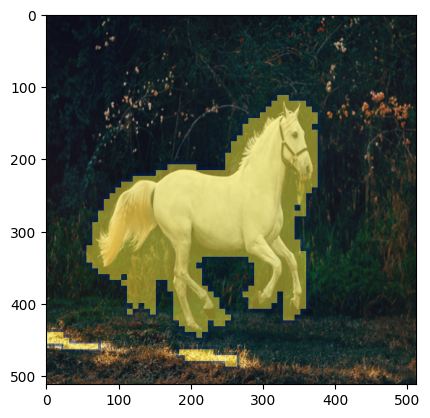

In [11]:
# 可视化
# 我发现调用pred_original_sample有个奇怪的bug，就是scheduler的一些alpha等参数不在gpu上，导致进行运算时会报错
# 我是改了ddim scheduler里面的库文件，把那些变量放到gpu才不会报错的

init_img = load_image('/home/tansq1/project/diffusers/image/3.png')
mask = create_mask_fast(init_img=init_img, rp=["a horse image"], qp=["a zebra image"], n=20)
plt.imshow(np.array(init_img), cmap='gray') # I would add interpolation='none'
plt.imshow(
    Image.fromarray(mask).resize((512,512)), ## Scaling the mask to original size
    cmap='cividis', 
    alpha=0.5*(np.array(Image.fromarray(mask*255).resize((512,512))) > 0)  
)